In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("seaborn-whitegrid")

In [3]:
RANDOM_SEED = 1234
SPLITS = 5

In [4]:
np.random.seed(RANDOM_SEED)

In [5]:
sst_dataset = load_dataset("ag_news")

Found cached dataset ag_news (/home/studio-lab-user/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
sst_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [7]:
sst_dataset["train"]["text"][0:2]

["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.']

In [8]:
sst = pd.DataFrame()
sst["text"] = sst_dataset["train"]["text"]
sst["label"] = sst_dataset["train"]["label"]

In [9]:
sst = sst.sample(frac=0.25)
sst.shape

(30000, 2)

In [10]:
sst.reset_index(inplace=True)

In [11]:
sst

,index,text,label
0,60974,Sharon Accepts Plan to Reduce Gaza Army Operat...,0
1,50391,Internet Key Battleground in Wildlife Crime Fi...,3
2,9307,July Durable Good Orders Rise 1.7 Percent Amer...,2
3,35221,Growing Signs of a Slowing on Wall Street all ...,2
4,40081,The New Faces of Reality TV The introduction o...,0
...,...,...,...
29995,29982,Pre-Inca Ruins Emerging From Peru's Cloud Fore...,3
29996,25590,New toys for wireless crowd As co-stars of an ...,2
29997,94314,#39;I only wish my dead comrades were here to...,0
29998,99695,Revamp aimed at getting Barbie's groove back B...,2


In [12]:
sst.drop(columns="index", inplace=True)

In [13]:
sst.head(2)

,text,label
0,Sharon Accepts Plan to Reduce Gaza Army Operat...,0
1,Internet Key Battleground in Wildlife Crime Fi...,3


In [14]:
sst.label.value_counts(normalize=True)

2    0.252133
0    0.251867
1    0.248067
3    0.247933
Name: label, dtype: float64

In [15]:
def get_dict_size(text):
    vec = TfidfVectorizer(lowercase=True, ngram_range=(1,1), analyzer="word").fit(text)
    DICT_SIZE = len(vec.get_feature_names_out())
    return DICT_SIZE

In [16]:
DICT_SIZE = get_dict_size(sst["text"])
print(DICT_SIZE)

38817


In [17]:
pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                   LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)
                  )

In [18]:
pl.fit(sst["text"], sst["label"])

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=34935)),
                ('logisticregression',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=250, random_state=1234))])

In [19]:
pl.score(sst["text"], sst["label"])

0.9336

In [20]:
cv = StratifiedKFold(n_splits=SPLITS)
cross_validate(pl, sst["text"], sst["label"], cv=cv, scoring={"accuracy", "f1_weighted"})

{'fit_time': array([ 9.8701067 , 10.98286891, 11.98489475,  8.84603429, 11.0091908 ]),
 'score_time': array([0.25503111, 0.25255108, 0.28207803, 0.35421991, 0.32282782]),
 'test_f1_weighted': array([0.89976445, 0.89549902, 0.90250708, 0.9006569 , 0.89647237]),
 'test_accuracy': array([0.90016667, 0.896     , 0.90283333, 0.901     , 0.89683333])}

In [21]:
acc_scores = []
f1_scores = []
fold = []
lab_perc = []
i_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
t0  = time.time()
for i in i_range:
    sst["ss_label"] = np.where(sst.index.isin(sst.sample(frac=1-i).index), -1, sst.label)
    ss_pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                          SelfTrainingClassifier(
                          LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)))
    
    for f, (train, test), in zip(range(SPLITS), cv.split(sst["text"], sst["label"])):
        ss_pl.fit(sst["text"][train], sst["ss_label"][train])
        ss_pl_preds = ss_pl.predict(sst["text"][test])
        acc_scores.append(accuracy_score(sst["label"][test], ss_pl_preds))
        f1_scores.append(f1_score(sst["label"][test], ss_pl_preds, average="weighted"))
        fold.append(f)
        lab_perc.append(i)

t1 = time.time()
exec_time = t1-t0
print(f"Execution time: {exec_time/60:.3f} minutes")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_s

Execution time: 63.541 minutes


In [22]:
dataset_report = pd.DataFrame({"acc_scores": acc_scores,
                               "f1_scores": f1_scores,
                               "fold_number": fold,
                               "dataset_name": ["AG_News_30K_Train"] * len(acc_scores),
                               "classes": [sst["label"].nunique()] * len(acc_scores),
                               "dataset_len": [sst.shape[0]] * len(acc_scores),
                               "percent_labeled_samples": lab_perc,
                                "exec_time_secs_9_runs": [exec_time] * len(acc_scores)})

In [23]:
dataset_report

,acc_scores,f1_scores,fold_number,dataset_name,classes,dataset_len,percent_labeled_samples,exec_time_secs_9_runs
0,0.822000,0.819441,0,AG_News_30K_Train,4,30000,0.1,3812.445608
1,0.829167,0.827159,1,AG_News_30K_Train,4,30000,0.1,3812.445608
2,0.827833,0.825643,2,AG_News_30K_Train,4,30000,0.1,3812.445608
3,0.832500,0.830556,3,AG_News_30K_Train,4,30000,0.1,3812.445608
4,0.832500,0.831183,4,AG_News_30K_Train,4,30000,0.1,3812.445608
5,0.855000,0.853632,0,AG_News_30K_Train,4,30000,0.2,3812.445608
6,0.861000,0.859772,1,AG_News_30K_Train,4,30000,0.2,3812.445608
7,0.855833,0.854466,2,AG_News_30K_Train,4,30000,0.2,3812.445608
8,0.862167,0.861094,3,AG_News_30K_Train,4,30000,0.2,3812.445608
9,0.864833,0.864176,4,AG_News_30K_Train,4,30000,0.2,3812.445608


<AxesSubplot:xlabel='percent_labeled_samples', ylabel='acc_scores'>

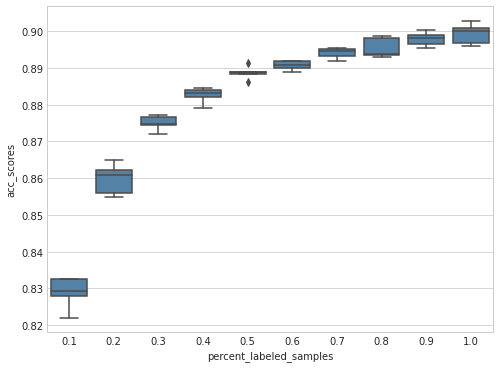

In [24]:
plt.figure(figsize=(8,6))
sns.boxplot(data=dataset_report, x="percent_labeled_samples", y="acc_scores", color="steelblue")

In [25]:
dataset_report.to_csv("ag_news_30K.csv", index_label=False)

In [26]:
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
# ax[0].scatter(i_range, acc_scores)
# ax[0].plot(i_range, acc_scores)
# ax[0].set_xlabel("Percent of Labeled Samples")
# ax[0].set_ylabel("Accuracy Score")
# ax[0].set_title("% of Labeled Samples Vs Accuracy Score", fontweight="bold")
# ax[1].scatter(i_range, f1_scores)
# ax[1].plot(i_range, f1_scores)
# ax[1].set_xlabel("Percent of Labeled Samples")
# ax[1].set_ylabel("F1 Score")
# ax[1].set_title("% of Labeled Samples Vs F1 Score", fontweight="bold")
# plt.show()